In [2]:
import pandas as pd   
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
import shutil
import gc
from pathlib import Path
# from tsmoothie.smoother import *
from statistics import mean

# Notebook for preprocessing data from experiments

Set working directory. Default is `experiments_data`.

In [3]:
working_directory = "2GB-9N-spark-listener"

In [9]:
def get_subdirectories(directory=""):
    subdirectories = []
    p = Path(f"./../{working_directory}/{directory}")
    for item in p.glob('*/'):
        if item.suffix not in (['.csv', '.zip']):
            subdirectories.append(directory + "/" + item.name)
    return subdirectories

def get_timestamp_info(data):
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    start_time = data['timestamp'].min()
    stop_time = data['timestamp'].max()

    data['timestamp'] = pd.to_numeric(data['timestamp'])
    mean_interval = mean(data.diff(axis=0)['timestamp'][1:].tolist())
    mean_interval = round(mean_interval / 1000000000, 3)

    return (stop_time - start_time).total_seconds(), mean_interval

def preprocess_file(file_path, save_path, filename, iteration):
    read_data = pd.read_csv(file_path + "/" + filename)
    agg_read_data = read_data.\
        groupby('timestamp', as_index=False).\
        agg({"CPU": "sum", "RAM": "sum"})

    generate_plot(agg_read_data.index, agg_read_data.CPU, "{0}/CPU/{1}_CPU.png".format(save_path, iteration), ylabel="Procentowe zużycie CPU")
    generate_plot(agg_read_data.index, agg_read_data.RAM, "{0}/RAM/{1}_RAM.png".format(save_path, iteration), ylabel="Procentowe zużycie RAM")

    return agg_read_data, get_timestamp_info(agg_read_data)

def generate_plot(data_x="", data_y="", plot_path="", title="", ylabel=""):
    fig = plt.figure(figsize=(10,10))
    fig.patch.set_facecolor('white')
    plt.plot(data_x, data_y, 'r.-')
    plt.title(title)
    plt.xlabel("Numer próbki", fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.savefig(plot_path)
    plt.close(fig)

def create_directory(path):
    try:
        os.mkdir(path)
    except OSError as e:
        print("Error: %s - %s." % (e.filename, e.strerror))

Check for subdirectories. Number of subdirectories should much the number of nodes used for experiments.

In [6]:
all_directories = get_subdirectories()
nodes_directories = [x for x in all_directories if "node" in x]
nodes_directories

['/node_11',
 '/node_12',
 '/node_13',
 '/node_14',
 '/node_15',
 '/node_16',
 '/node_17',
 '/node_18',
 '/node_19',
 '/node_20']

In [7]:
data_directories = []
data_directories_groups = []
for directory in nodes_directories:
    cur_node_subdirectories = get_subdirectories(directory)
    data_directories.append(cur_node_subdirectories)

data_directories_groups = data_directories
data_directories = [item for sublist in data_directories for item in sublist]
data_directories_groups

[['/node_11/avgNetProfitGroupedBySoldDate',
  '/node_11/avgNetProfitGroupedBySoldDateWhereProfitNegative',
  '/node_11/avgNetProfitGroupedBySoldDateWhereYearAfter2000',
  '/node_11/avgWholeSaleCostGroupedBySoldDate',
  '/node_11/countNetProfitGroupedBySoldDate',
  '/node_11/countNetProfitGroupedBySoldDateWhereProfitNegative',
  '/node_11/countNetProfitGroupedBySoldDateWhereYearAfter2000',
  '/node_11/countWholeSaleCostGroupedBySoldDate',
  '/node_11/filterCatalogSalesWhereProfitNegative',
  '/node_11/filterCatalogSalesWhereProfitNegativeAndYearAfter2000',
  '/node_11/filterCatalogSalesWhereYearAfter2000',
  '/node_11/filterStoreSalesWhereProfitNegative',
  '/node_11/filterStoreSalesWhereProfitNegativeAndYearAfter2000',
  '/node_11/filterStoreSalesWhereYearAfter2000',
  '/node_11/maxNetProfitGroupedBySoldDate',
  '/node_11/maxNetProfitGroupedBySoldDateWhereProfitNegative',
  '/node_11/maxNetProfitGroupedBySoldDateWhereYearAfter2000',
  '/node_11/maxWholeSaleCostGroupedBySoldDate',
  '/n

Check for function names in each node directory.
These names should match the names in `experiments-plan.csv`.


In [8]:
function_names = data_directories_groups[1]
function_names = list(map(lambda x: x[8:], data_directories_groups[1]))
function_names

['/avgNetProfitGroupedBySoldDate',
 '/avgNetProfitGroupedBySoldDateWhereProfitNegative',
 '/avgNetProfitGroupedBySoldDateWhereYearAfter2000',
 '/avgWholeSaleCostGroupedBySoldDate',
 '/countNetProfitGroupedBySoldDate',
 '/countNetProfitGroupedBySoldDateWhereProfitNegative',
 '/countNetProfitGroupedBySoldDateWhereYearAfter2000',
 '/countWholeSaleCostGroupedBySoldDate',
 '/filterCatalogSalesWhereProfitNegative',
 '/filterCatalogSalesWhereProfitNegativeAndYearAfter2000',
 '/filterCatalogSalesWhereYearAfter2000',
 '/filterStoreSalesWhereProfitNegative',
 '/filterStoreSalesWhereProfitNegativeAndYearAfter2000',
 '/filterStoreSalesWhereYearAfter2000',
 '/maxNetProfitGroupedBySoldDate',
 '/maxNetProfitGroupedBySoldDateWhereProfitNegative',
 '/maxNetProfitGroupedBySoldDateWhereYearAfter2000',
 '/maxWholeSaleCostGroupedBySoldDate',
 '/minNetProfitGroupedBySoldDate',
 '/minNetProfitGroupedBySoldDateWhereProfitNegative',
 '/minNetProfitGroupedBySoldDateWhereYearAfter2000',
 '/minWholeSaleCostGroupe

### Aggregating data from all nodes (11-19)

In [9]:
master_dir_index = nodes_directories.index('/node_20')
workers_directories = nodes_directories.copy()
del workers_directories[master_dir_index]

workers_directories

['/node_11',
 '/node_12',
 '/node_13',
 '/node_14',
 '/node_15',
 '/node_16',
 '/node_17',
 '/node_18',
 '/node_19']

In [10]:
create_directory(f"./../{working_directory}/preprocessed-data")

mean_dir = f"./../{working_directory}/preprocessed-data/workers-mean-data"
create_directory(mean_dir)
workers_summary = pd.DataFrame(columns=["function_name",
                                             "mean_duration",
                                             "mean_interval",
                                             "nodes_durations",
                                             "nodes_intervals"])

workers_summary.to_csv("{0}/experiments_mean_duration.csv".format(mean_dir), index=False)

Error: ./../2GB-9N-spark-listener/preprocessed-data - Nie można utworzyć pliku, który już istnieje.
Error: ./../2GB-9N-spark-listener/preprocessed-data/workers-mean-data - Nie można utworzyć pliku, który już istnieje.


In [11]:
def preprocess_selected_function(f_names, workers_summary):
    for function_name in f_names:
        base_data = pd.DataFrame()
        experiment_duration = []
        experiment_interval = []
        nodes_durations = []
        nodes_intervals = []

        experiment_mean_dir = "{0}{1}".format(mean_dir, function_name)
        create_directory(experiment_mean_dir)

        for node_dir in workers_directories:
            file_path = f"./../{working_directory}{node_dir}{function_name}"
            p = Path(file_path)
            plots_path = "{0}/plots".format(file_path)

            create_directory(plots_path)
            create_directory(plots_path + "/RAM")
            create_directory(plots_path + "/CPU")

            experiment_number = 1
            node_intervals = []
            node_durations = []

            for file in p.glob('*.csv'):
                new_data, (duration, interval) = preprocess_file(file_path, plots_path, file.name, experiment_number)
                base_data = pd.concat((base_data, new_data))

                experiment_duration.append(duration)
                experiment_interval.append(interval)
                node_intervals.append(interval)
                node_durations.append(duration)

                experiment_number += 1

            print("{0} | {1} durations: {2}".format(function_name[1:], node_dir[1:], node_durations))

            nodes_intervals.append((node_dir[1:], round(mean(node_intervals), 3)))
            nodes_durations.append((node_dir[1:], round(mean(node_durations), 3)))

        mean_interval = round(mean(experiment_interval), 3)

        base_data["timestamp"] = base_data.apply(lambda row: mean_interval * row.name, axis = 1)
        base_data = base_data.groupby(base_data.index).mean()
        base_data.to_csv("{0}/mean_data.csv".format(experiment_mean_dir), index=False)

        generate_plot(base_data.index, base_data.CPU, "{0}/mean_CPU.png".format(experiment_mean_dir), function_name[1:] + " CPU", ylabel="Procentowe zużycie CPU")
        generate_plot(base_data.index, base_data.RAM, "{0}/mean_RAM.png".format(experiment_mean_dir), function_name[1:] + " RAM", ylabel="Procentowe zużycie RAM")

        workers_summary = workers_summary.append({"function_name": function_name[1:],
                                                            "mean_duration": round(mean(experiment_duration), 3),
                                                            "mean_interval": mean_interval,
                                                            "nodes_durations": nodes_durations,
                                                            "nodes_intervals": nodes_intervals}, ignore_index=True)

    workers_summary.to_csv("{0}/experiments_mean_duration.csv".format(mean_dir), index=False, mode="a", header=False)

    del base_data
    del experiment_interval
    del experiment_duration
    del nodes_durations
    del nodes_intervals
    del new_data
    del node_intervals
    del node_durations
    del workers_summary
    gc.collect()

In [12]:
print(f"Functions: {len(function_names)}")

Functions: 28


In [13]:
preprocess_selected_function(function_names[0:4], workers_summary)

Error: ./../2GB-9N-spark-listener/preprocessed-data/workers-mean-data/avgNetProfitGroupedBySoldDate - Nie można utworzyć pliku, który już istnieje.
Error: ./../2GB-9N-spark-listener/node_11/avgNetProfitGroupedBySoldDate/plots - Nie można utworzyć pliku, który już istnieje.
Error: ./../2GB-9N-spark-listener/node_11/avgNetProfitGroupedBySoldDate/plots/RAM - Nie można utworzyć pliku, który już istnieje.
Error: ./../2GB-9N-spark-listener/node_11/avgNetProfitGroupedBySoldDate/plots/CPU - Nie można utworzyć pliku, który już istnieje.
avgNetProfitGroupedBySoldDate | node_11 durations: [75.617426, 81.921216, 115.250959, 90.102612, 83.642518, 88.211326, 91.03458, 114.454795, 87.906797, 89.154313, 89.095469, 128.585716, 85.858125, 88.053029, 119.336517, 89.776026, 89.776034, 86.16495, 86.170587, 121.195235, 88.992776, 94.971442, 116.031863, 89.155557, 87.887605]
avgNetProfitGroupedBySoldDate | node_12 durations: [75.619632, 81.692906, 115.280751, 89.950068, 83.569651, 88.071983, 91.019049, 114.3

In [14]:
gc.collect()

4918525

In [15]:
preprocess_selected_function(function_names[4:8], workers_summary)

countNetProfitGroupedBySoldDate | node_11 durations: [74.848017, 121.411503, 86.871233, 76.584208, 76.579207, 92.78657, 87.916142, 88.066721, 80.98118, 76.736351, 119.98516, 87.913388, 84.920649, 86.772157, 91.987026, 88.852881, 115.080518, 90.894199, 85.847809, 76.762645, 87.832972, 86.803521, 84.919808, 119.314193, 83.66941]
countNetProfitGroupedBySoldDate | node_12 durations: [74.825135, 121.356113, 86.815597, 76.584236, 76.55009, 92.750672, 87.769045, 88.067866, 80.933317, 76.701965, 119.959368, 87.938762, 84.836084, 86.676473, 91.956605, 88.683375, 114.978387, 90.871495, 85.744333, 76.713118, 87.76624, 86.688073, 84.801137, 119.342015, 83.585407]
countNetProfitGroupedBySoldDate | node_13 durations: [74.7137, 121.2446, 86.691036, 76.435121, 76.434529, 92.638228, 87.638732, 87.969508, 80.802482, 76.646428, 119.909027, 87.776489, 84.769273, 86.539619, 91.840564, 88.696964, 114.868932, 90.745454, 85.780569, 76.570105, 87.638576, 86.543029, 84.672996, 119.217472, 83.607391]
countNetPro

In [16]:
gc.collect()

4918708

In [17]:
preprocess_selected_function(function_names[8:12], workers_summary)

filterCatalogSalesWhereProfitNegative | node_11 durations: [22.014344, 24.053962, 21.064842, 22.948834, 22.169002, 23.123414, 24.993903, 24.994915, 23.114927, 22.170919, 22.146901, 22.014774, 22.040685, 22.169824, 22.965886, 22.024023, 21.998419, 22.295906, 22.00985, 21.223733, 22.176171, 22.17074, 22.011975, 24.057829, 22.013201]
filterCatalogSalesWhereProfitNegative | node_12 durations: [21.868063, 23.972916, 21.012796, 22.890582, 21.994496, 22.894436, 24.981498, 24.913487, 23.038523, 22.011509, 22.105816, 21.960429, 21.948696, 22.102371, 22.904673, 21.959932, 21.953364, 22.112994, 21.963145, 21.060459, 22.118073, 22.146472, 21.958535, 23.970314, 22.016061]
filterCatalogSalesWhereProfitNegative | node_13 durations: [21.804978, 23.913943, 20.801787, 22.747031, 21.957427, 22.913243, 24.916276, 24.85105, 22.890631, 21.954532, 22.041191, 21.815844, 21.811251, 21.885462, 22.910011, 21.806388, 21.80691, 22.11828, 21.811095, 21.034186, 21.968157, 21.959021, 21.953607, 23.833481, 21.805711]


In [18]:
gc.collect()

5074895

In [19]:
preprocess_selected_function(function_names[12:16], workers_summary)

filterStoreSalesWhereProfitNegativeAndYearAfter2000 | node_11 durations: [33.456209, 32.386506, 38.364144, 30.336481, 37.25829, 34.269387, 38.237914, 36.317637, 32.1851, 31.138678, 31.261796, 32.063719, 33.487978, 32.514028, 33.298407, 32.08175, 30.181976, 38.520632, 37.281671, 38.212929, 33.163853, 33.144335, 39.472273, 32.237299, 31.131474]
filterStoreSalesWhereProfitNegativeAndYearAfter2000 | node_12 durations: [33.160799, 32.232547, 38.278497, 30.200082, 37.041876, 34.246617, 38.133922, 36.225155, 32.077935, 30.999419, 31.235241, 32.025622, 33.461934, 32.382556, 33.174391, 32.029682, 30.051129, 38.447727, 37.198379, 38.120634, 32.980677, 32.998416, 39.465482, 32.0344, 30.976682]
filterStoreSalesWhereProfitNegativeAndYearAfter2000 | node_13 durations: [33.082126, 32.051496, 38.162721, 30.166782, 37.067583, 34.099641, 38.001646, 36.192089, 32.087338, 31.002177, 31.153855, 31.936326, 33.295259, 32.391349, 33.040502, 31.882302, 29.914336, 38.317837, 37.186239, 38.012409, 32.878101, 33.

In [20]:
gc.collect()

4954801

In [21]:
preprocess_selected_function(function_names[16:20], workers_summary)

Error: ./../2GB-9N-spark-listener/preprocessed-data/workers-mean-data/maxNetProfitGroupedBySoldDateWhereYearAfter2000 - Nie można utworzyć pliku, który już istnieje.
Error: ./../2GB-9N-spark-listener/node_11/maxNetProfitGroupedBySoldDateWhereYearAfter2000/plots - Nie można utworzyć pliku, który już istnieje.
Error: ./../2GB-9N-spark-listener/node_11/maxNetProfitGroupedBySoldDateWhereYearAfter2000/plots/RAM - Nie można utworzyć pliku, który już istnieje.
Error: ./../2GB-9N-spark-listener/node_11/maxNetProfitGroupedBySoldDateWhereYearAfter2000/plots/CPU - Nie można utworzyć pliku, który już istnieje.
maxNetProfitGroupedBySoldDateWhereYearAfter2000 | node_11 durations: [84.849998, 115.208797, 108.117614, 87.818043, 85.776212, 112.055034, 86.724388, 85.13967, 116.47636, 114.121416, 86.882428, 121.025179, 84.82125, 82.81113, 87.053021, 91.905391, 121.188667, 81.78957, 90.353062, 90.813751, 84.834962, 86.887392, 93.952202, 88.876801, 88.82284]
maxNetProfitGroupedBySoldDateWhereYearAfter2000 

In [22]:
gc.collect()

4928965

In [23]:
preprocess_selected_function(function_names[20:24], workers_summary)

Error: ./../2GB-9N-spark-listener/preprocessed-data/workers-mean-data/minNetProfitGroupedBySoldDateWhereYearAfter2000 - Nie można utworzyć pliku, który już istnieje.
Error: ./../2GB-9N-spark-listener/node_11/minNetProfitGroupedBySoldDateWhereYearAfter2000/plots - Nie można utworzyć pliku, który już istnieje.
Error: ./../2GB-9N-spark-listener/node_11/minNetProfitGroupedBySoldDateWhereYearAfter2000/plots/RAM - Nie można utworzyć pliku, który już istnieje.
Error: ./../2GB-9N-spark-listener/node_11/minNetProfitGroupedBySoldDateWhereYearAfter2000/plots/CPU - Nie można utworzyć pliku, który już istnieje.
minNetProfitGroupedBySoldDateWhereYearAfter2000 | node_11 durations: [87.820386, 99.011105, 88.103636, 91.941617, 87.829076, 85.157592, 113.015655, 85.89536, 82.779566, 88.014497, 87.047204, 85.811936, 94.929443, 88.773712, 83.888772, 95.878417, 84.824949, 114.130258, 93.18397, 119.309947, 88.915068, 84.829717, 87.056774, 122.137603, 122.177823]
minNetProfitGroupedBySoldDateWhereYearAfter200

In [24]:
gc.collect()

4894528

In [25]:
preprocess_selected_function(function_names[24:28], workers_summary)

sumNetProfitGroupedBySoldDate | node_11 durations: [88.895613, 87.039433, 89.126693, 87.05643, 85.997258, 92.133115, 120.127847, 80.812335, 92.143445, 87.727376, 118.390503, 86.000002, 88.833154, 86.947033, 87.880881, 120.122965, 85.850513, 120.113647, 92.929046, 95.127782, 86.784819, 89.937894, 88.040155, 118.058631, 88.75969]
sumNetProfitGroupedBySoldDate | node_12 durations: [88.692518, 86.823025, 88.995959, 87.009402, 85.879062, 91.962746, 119.963787, 80.690765, 91.978655, 87.61009, 118.235142, 85.754807, 88.69636, 86.918714, 87.760838, 120.093803, 85.728448, 120.096765, 92.878525, 95.056993, 86.689196, 89.898383, 87.905119, 117.942231, 88.672917]
sumNetProfitGroupedBySoldDate | node_13 durations: [88.569822, 86.700003, 88.723672, 86.879191, 85.770188, 91.814271, 119.989233, 80.622306, 91.982863, 87.490574, 118.273662, 85.770296, 88.727613, 86.860366, 87.630607, 120.009109, 85.591965, 119.984602, 92.763987, 94.94743, 86.486976, 89.7988, 87.782641, 117.960212, 88.548786]
sumNetProfi

In [26]:
gc.collect()

4891366

In [27]:
preprocess_selected_function(function_names[28:], workers_summary)

UnboundLocalError: local variable 'base_data' referenced before assignment

In [ ]:
gc.collect()

### Aggregating data from master node #20

Error: ./../2GB-9N-spark-listener/preprocessed-data - Nie można utworzyć pliku, który już istnieje.
Progress:


ValueError: x and y must have same first dimension, but have shapes (150,) and (479,)

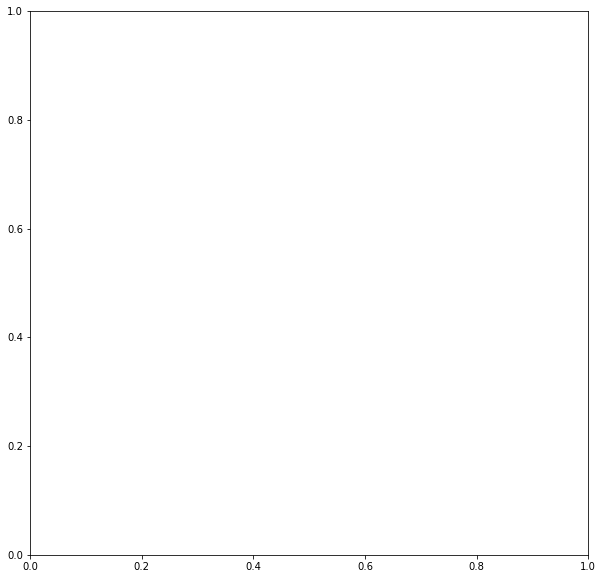

In [20]:
create_directory(f"./../{working_directory}/preprocessed-data")

master_dir = f"./../{working_directory}/preprocessed-data/master-mean-data"
create_directory(master_dir)
master_mean_summary = pd.DataFrame(columns=["function_name",
                                            "mean_duration",
                                            "mean_interval"])

print("Progress:")
for function in function_names:
    files_path = f"./../{working_directory}/node_20{function}"
    p = Path(files_path)
    master_data = pd.DataFrame()

    experiment_durations = []
    experiment_intervals = []

    master_experiment_directory = "{0}{1}".format(master_dir, function)
    master_plot_directory = "{0}/plots".format(files_path)

    create_directory(master_experiment_directory)
    create_directory(master_plot_directory)
    create_directory("{0}/CPU".format(master_plot_directory))
    create_directory("{0}/RAM".format(master_plot_directory))

    experiment_number = 1
    for file in p.glob('*.csv'):
        master_new_data, (duration, interval) = preprocess_file(files_path, master_plot_directory, file.name, experiment_number)
        master_data = pd.concat((master_data, master_new_data))
        experiment_durations.append(duration)
        experiment_intervals.append(interval)
        experiment_number += 1

    master_mean_summary = master_mean_summary.append({"function_name": function[1:],
                                                      "mean_duration": round(mean(experiment_durations), 3),
                                                      "mean_interval": round(mean(experiment_intervals), 3)},
                                                     ignore_index=True)

    master_data = master_data.groupby(master_data.index).mean()
    master_data.to_csv("{0}/mean_data.csv".format(master_experiment_directory), index=False)

    generate_plot(master_data.index, master_data.CPU, "{0}/mean_CPU.png".format(master_experiment_directory), ylabel="Średnie procentowe zużycie CPU")
    generate_plot(master_data.index, master_data.RAM, "{0}/mean_RAM.png".format(master_experiment_directory), ylabel="Średnie procentowe zużycie RAM")

    print("- {0} - done".format(function[1:]))

    # Deleting variables
    del master_data
    del experiment_intervals
    del experiment_durations
    del master_new_data

master_mean_summary.to_csv("{0}/experiments_mean_duration.csv".format(master_dir), index=False)

del master_mean_summary
gc.collect()

### Preprocessing spark internal metrics

Stage and task metrics

In [ ]:
stage_metrics_all = pd.read_csv(f"./../{working_directory}/stage_metrics.csv")
task_metrics_all = pd.read_csv(f"./../{working_directory}/task_metrics.csv")

stage_metrics = stage_metrics_all[["function_name", "stage_id", "num_tasks", "executor_run_time", "result_size"]].copy()
stage_metrics["stage_time"]= stage_metrics_all["completion_time"] - stage_metrics_all["submission_time"]
stage_metrics = stage_metrics.groupby(["function_name", "stage_id"]).agg({
    "stage_time": "mean",
    "num_tasks": "max",
    "executor_run_time": "mean",
    "result_size": "mean"
})

task_metrics = task_metrics_all[["function_name", "stage_id", "task_type"]]
task_metrics = task_metrics.groupby(["function_name", "stage_id"]).agg({"task_type": "unique"})

spark_metrics = task_metrics.join(stage_metrics).reset_index().rename(columns={
    "stage_time": "mean_stage_time",
    "task_type": "task_types",
    "executor_run_time": "mean_executor_run_time",
    "result_size": "mean_result_size"
})

spark_metrics.to_csv(f"./../{working_directory}/preprocessed-data/spark_metrics.csv", index=False)
spark_metrics

### Clear preprocessed data

In [1]:
for function_name in function_names:
    for node_dir in nodes_directories:
        try:
            shutil.rmtree(f"./../{working_directory}{node_dir}{function_name}/plots")
        except OSError as e:
            print("Error: %s - %s." % (e.filename, e.strerror))

try:
    shutil.rmtree(f"./../{working_directory}/preprocessed-data")
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))


NameError: name 'function_names' is not defined

## Clear smoothed data

In [32]:
for function_name in function_names:
    try:
        os.remove(f'./../experiments_data/preprocessed-data/workers-mean-data{function_name}/smooth_mean_CPU.png')
        os.remove(f'./../experiments_data/preprocessed-data/workers-mean-data{function_name}/smooth_mean_data.csv')
        os.remove(f'./../experiments_data/preprocessed-data/workers-mean-data{function_name}/smooth_mean_RAM.png')
    except OSError as e:
        print("Error: %s - %s." % (e.filename, e.strerror))


## Plots with 150 samples

In [11]:
preprocess_file("./../1GB-5N/node_11/minNetProfitGroupedBySoldDateWhereYearAfter2000", "./../overleaf/figures/first", "08_08_2021_09_56_17.csv", 5)
preprocess_file("./../1GB-5N/node_11/filterCatalogSalesWhereProfitNegative", "./../overleaf/figures/first", "08_08_2021_02_06_21.csv", 17)
preprocess_file("./../1GB-5N/node_11/avgWholeSaleCostGroupedBySoldDate", "./../overleaf/figures/first", "07_08_2021_11_34_29.csv", 16)
preprocess_file("./../1GB-5N/node_11/maxNetProfitGroupedBySoldDateWhereProfitNegative", "./../overleaf/figures/first", "08_08_2021_07_04_51.csv", 2)
preprocess_file("./../1GB-5N/node_11/filterStoreSalesWhereYearAfter2000", "./../overleaf/figures/first", "08_08_2021_03_35_44.csv", 12)


(               timestamp    CPU  RAM
 0    1628393744649273000  213.3  5.9
 1    1628393744805647000  206.7  6.1
 2    1628393744963275000  140.0  6.3
 3    1628393745120312000  140.0  6.4
 4    1628393745277183000  126.7  6.5
 ..                   ...    ...  ...
 197  1628393775691554000    0.0  5.2
 198  1628393775848865000    0.0  5.2
 199  1628393776006404000    0.0  5.2
 200  1628393776163769000    0.0  5.2
 201  1628393776321209000    0.0  5.2
 
 [202 rows x 3 columns],
 (31.671936, 0.158))

## Overhead measurement

In [5]:
data_listener = pd.read_csv(f"./../1GB-9N-spark-listener/preprocessed-data/workers-mean-data/experiments_mean_duration.csv")[["function_name","mean_duration"]]
data_no_listener = pd.read_csv(f"./../1GB-9N/preprocessed-data/workers-mean-data/experiments_mean_duration.csv")[["function_name","mean_duration"]]
listener_mean_data_comparison = pd.merge(data_listener, data_no_listener, on="function_name")
listener_mean_data_comparison["delta_length [listener minus no listener]"] = round(listener_mean_data_comparison["mean_duration_x"] - listener_mean_data_comparison["mean_duration_y"], 3)
listener_mean_data_comparison = listener_mean_data_comparison.rename(columns={"mean_duration_x": "mean_duration_listener",
                                              "mean_duration_y": "mean_duration_no_listener"})
listener_mean_data_comparison.to_csv(f"./../1GB-9N-spark-listener/preprocessed-data/workers-mean-data/mean_duration_comparison.csv", index=False)

